In [1]:
from QHyper.problems import KnapsackProblem
from QHyper.solvers import solver_from_config
from QHyper.util import (
    weighted_avg_evaluation, sort_solver_results, add_evaluation_to_results)

import numpy as np


problem_config = {  # This is going to be used later
    'type': 'knapsack',
    'max_weight': 8,
    'items': [(1, 2), (2, 4), (1, 2), (1, 1), (4, 5)]
}

params_config = {
    'angles': [[0.5]*5, [1]*5],
    'hyper_args': [1, 2.5, 2.5],
}
hyper_optimizer_bounds = 3*[(1, 10)]
penalty = 5


In [2]:
def get_solver_config_1(angles):
    return {
        "solver": {
            "type": "vqa",
            # "optimizer": {
            #     # "type": "scipy",
            #     # "maxfun": 200,

            #     "type": "random",
            #     "number_of_samples": 10,
            #     "bounds": 10*[(0, 2*np.pi)],
            #     # "type": "cem",
            #     "processes": 10,
            #     # "samples_per_epoch": 500,
            #     # "epochs": 5,
            #     # "bounds": 10*[(0, 2*np.pi)],
            #     # "verbose": True,
            #     "disable_tqdm": True,
            # },
            "pqc": {
                "type": "qaoa",
                "layers": 5,
                # "dev": "lightning.gpu",
                # "limit_results": 20,b
                # "penalty": penalty,
            },
            "params_inits": {
                'angles': angles,
                'hyper_args': [1, 2.5, 2.5],
            },
            # "hyper_optimizer": {
            #     "type": "cem",
            #     "processes": 5,
            #     "samples_per_epoch": 5000,
            #     "epochs": 5,
            #     "bounds": hyper_optimizer_bounds,
            # }
        },
        "problem": problem_config
    }

def get_solver_config_2(angles):
    return {
        "solver": {
            "type": "vqa",
            # "optimizer": {
            #     # "type": "scipy",
            #     # "maxfun": 200,

            #     "type": "random",
            #     "number_of_samples": 10,
            #     "bounds": 10*[(0, 2*np.pi)],
            #     # "type": "cem",
            #     "processes": 10,
            #     # "samples_per_epoch": 500,
            #     # "epochs": 5,
            #     # "bounds": 10*[(0, 2*np.pi)],
            #     # "verbose": True,
            #     "disable_tqdm": True,
            # },
            "pqc": {
                "type": "wfqaoa",
                "layers": 5,
                # "limit_results": 20,b
                "penalty": penalty,
                # "dev": "lightning.gpu",
            },
            "params_inits": {
                'angles': angles,
                'hyper_args': [1, 2.5, 2.5],
            },
            # "hyper_optimizer": {
            #     "type": "cem",
            #     "processes": 5,
            #     "samples_per_epoch": 5000,
            #     "epochs": 5,
            #     "bounds": hyper_optimizer_bounds,
            # }
        },
        "problem": problem_config
    }


In [3]:
def run_solver1(inits):
    solver_config = get_solver_config_1(inits)
    solver = solver_from_config(solver_config)
    results = solver.solve()
    return results

def run_solver2(inits):
    solver_config = get_solver_config_2(inits)
    solver = solver_from_config(solver_config)
    results = solver.solve()
    return results


In [4]:
import multiprocessing as mp
import tqdm

iterations = 1000

random_inits = np.random.rand(iterations, 2, 5)
with mp.Pool(processes=10) as p:
    results_1 = list(tqdm.tqdm(
        p.imap(
            run_solver1,
            random_inits,
        ),
        total=iterations,
    ))
    results_2 = list(tqdm.tqdm(
        p.imap(
            run_solver2,
            random_inits,
        ),
        total=iterations,
    ))


100%|██████████| 1000/1000 [11:01<00:00,  1.51it/s]


In [5]:
results_1[0].history[-1][-1].value


tensor(621.76032991, requires_grad=True)

In [6]:
import pandas as pd
from QHyper.problems import problem_from_config

problem = problem_from_config(problem_config)

results = pd.DataFrame([
    {
        'evaluation': weighted_avg_evaluation(
            result_1.probabilities,
            problem.get_score,
            limit_results=20, normalize=True
        ),
        'origin_result_1': result_1.history[-1][-1].value,
        'origin_result_2': result_2.history[-1][-1].value,
        # 'origin_result_3': weighted_avg_evaluation(
        #     result_1.probabilities,
        #     problem.get_score,
        #     penalty=penalty+50, normalize=True
        # ),
    }
    for result_1, result_2 in zip(results_1, results_2)
])
print(results.sort_values('evaluation'))


     evaluation    origin_result_1  origin_result_2
802   -1.100247  626.1055160962959         4.918794
447   -0.936391  618.1404759328673         4.939652
108   -0.772750  599.6775646111053         4.936850
188   -0.767448  613.2251298777907         4.928168
502   -0.678084  624.9685253762724         4.932376
..          ...                ...              ...
344    0.000000  634.6534396018739         4.934694
345    0.000000  615.7502585707216         4.953752
346    0.000000  621.9182465970393         4.931080
317    0.000000  622.8188344831592         4.954325
999    0.000000  606.1460773614117         4.947899

[1000 rows x 3 columns]


In [7]:
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))


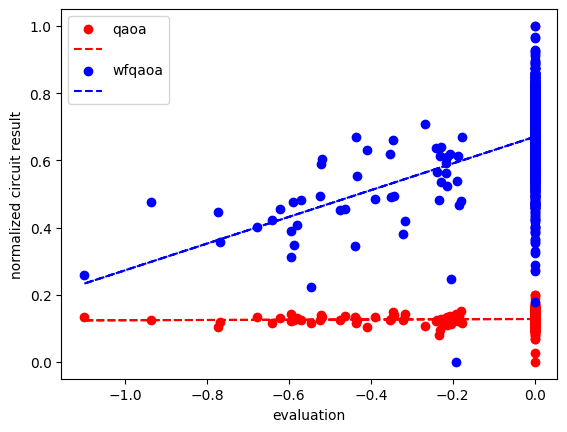

In [8]:
#draw plot where x is evaluation and y is origin_result_1 and origin_result_2 and origin_result_1 is red and origin_result_2 is blue
import matplotlib.pyplot as plt

def draw(color, res):
    plt.scatter(results.evaluation, normalize(res), c=color)
    z_1 = np.polyfit(results.evaluation.astype('float'), normalize(res).astype('float'), 1)
    # get the polynomial to generate the trendline
    p_1 = np.poly1d(z_1)
    # add trendline to the plot
    plt.plot(results.evaluation, p_1(results.evaluation), f"{color}--")


draw('r', results.origin_result_1)
draw('b', results.origin_result_2)
# draw('g', results.origin_result_3)
# plt.scatter(results.evaluation, normalize(results.origin_result_1), c='r')
# plt.scatter(results.evaluation, normalize(results.origin_result_2), c='b')
# z_1 = np.polyfit(results.evaluation.astype('float'), normalize(results.origin_result_1).astype('float'), 1)
# # get the polynomial to generate the trendline
# p_1 = np.poly1d(z_1)
# # add trendline to the plot
# plt.plot(results.evaluation, p_1(results.evaluation), "r--")

# z_2 = np.polyfit(results.evaluation.astype('float'), normalize(results.origin_result_2).astype('float'), 1)
# p_2 = np.poly1d(z_2)
# plt.plot(results.evaluation, p_2(results.evaluation), "b--")
plt.xlabel('evaluation')
plt.ylabel('normalized circuit result')
plt.legend(['qaoa', '', 'wfqaoa', ''])
plt.show()
